Dynamic Linear Model (DLM)은 다음과 같은 형태를 갖는다.

$$\theta_0\sim N(m_0,C_0)$$

$$Y_t=F_t\theta_t+v_t\;\;\;\;v_t\sim N(0,V_t)$$

$$\theta_t=G_t\theta_{t-1}+w_t\;\;\;\;w_t\sim N(0,W_t)$$

다음과 같은 모델을 생각해 보자.

$$
W_t=
\begin{cases}
100,&t \% 10 =0\\
0.01,&else
\end{cases}
$$

$$
V_t=
\begin{cases}
100,& 0 \leq t \% 10 \leq 3\\
0.01,&else
\end{cases}
$$

$$m_0=0,\;\;C_0=1$$

$$F_t=1,\;\;\;\;G_t=1$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
m0 = 0; C0 = 1; F = 1; G = 1;
N=100; 
theta = np.zeros(N); Y = np.zeros(N); W = np.ones(N)*1e-2; V = np.ones(N)*1e-2;
for i in range(N):
    if i%10 == 0:
        W[i] = 100;
    if i%10 >= 0 and i%10 <= 3:
        V[i] = 100;
theta[0] = norm.rvs(loc=m0,scale=np.sqrt(C0),size=1);

In [3]:
for i in range(1,N):
    theta[i] = G*theta[i-1] + norm.rvs(loc=0,scale=np.sqrt(W[i]),size=1);
    Y[i] = F*theta[i] + norm.rvs(loc=0,scale=np.sqrt(V[i]),size=1);

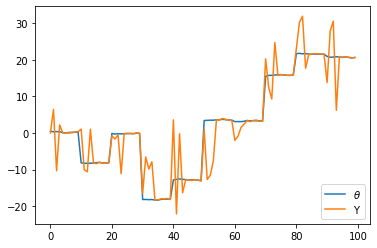

In [4]:
plt.plot(theta,label="$\\theta$"); plt.plot(Y,label='Y');
plt.legend(loc='lower right');

In [5]:
def norm_pdf(x,loc,scale):
    return (1/np.sqrt(2*np.pi*scale**2))*np.exp(-(1/(2*scale**2))*(loc-x)**2);

In [6]:
### Particle Filter
N_particle = 1000;
## 사전 분포에서 초기 입자 추출
## 사전 분포는 Normal로 가정함
pfOutTheta = np.zeros([N_particle,N]);
pfOutTheta[:,0] = norm.rvs(loc = theta[0], scale = 10, size=N_particle);
## 가중치 초기화
wt = np.ones([N_particle,N])/N_particle;
## Loop 시작
for t in range(1,N):
    for i in range(1,N_particle):
        # 가중치 전이 밀도에서 입자 샘플링
        Sig = F*W[t]*F+V[t];
        E = G*theta[t-1]+W[t]*F*(1/Sig)*(Y[t]-F*G*theta[t-1]);
        Var = W[t]-W[t]*F*(1/Sig)*F*W[t];
        pfOutTheta[i,t] = norm.rvs(loc = E, scale = np.sqrt(Var),size=1);
        # 정규화되지 않은 가중치 계산
        wt[i,t] = wt[i,t-1] * norm_pdf(x=pfOutTheta[i,t],loc=Y[t],scale=10);
    # 가중치 정규화
    wt[:,t] /= np.sum(wt[:,t])
    # N_eff 계산
    N_eff = 1/np.sum(wt[:,t]*wt[:,t]);
    # Resample
    if N_eff < N_particle/2:
        index = np.random.choice(N_particle,N_particle,replace=True,p = wt[:,t]);
        pfOutTheta[:,t] = pfOutTheta[index,t];
        wt[:,t] = np.ones(N_particle)/N_particle;

In [7]:
thetaHat = np.zeros(N);
for t in range(N):
    thetaHat[t] = np.average(pfOutTheta[:,t],weights=wt[:,t])

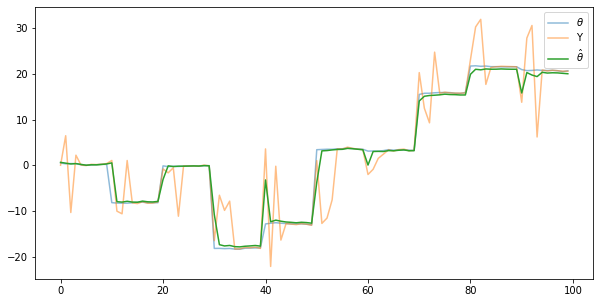

In [8]:
plt.figure(figsize=(10,5))
plt.plot(theta,alpha=0.5,label="$\\theta$");
plt.plot(Y,alpha=0.5,label="Y");
plt.plot(thetaHat,label="$\hat{\\theta}$");
plt.legend();